In [1]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import os
import sys
import re
import time
import copy
import json
from collections import defaultdict
from tqdm import tqdm
from multiprocess import Pool
from importlib import reload

import numpy as np
import pandas as pd
import scipy.sparse
import scipy.spatial
from scipy.interpolate import interp1d
from shapely import affinity
from shapely.geometry import Point, LineString, LinearRing, Polygon, MultiPolygon
from descartes import PolygonPatch
from sklearn.decomposition import PCA
import networkx as nx

from plt2video import fig2data, viz_video

Setting up a new session...


### Chemical universe setup
Molecules and reaction networks

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


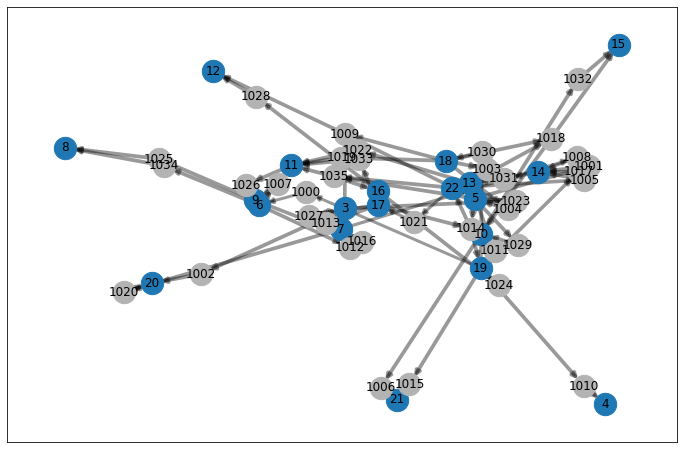

In [42]:
import chemistry
reload(chemistry)

reaction_graph = nx.DiGraph()
for i, m in enumerate(chemistry.molecule_types):
  if i < chemistry.n_base_molecules:
    continue
  reaction_graph.add_node(i, name=m, energy=chemistry.molecule_energy[i])
  
for i, r in enumerate(chemistry.reactions):
  r_id = 1000 + i
  reaction_graph.add_node(r_id, name=r_id)
  for reactant in r['reactants']:
    reaction_graph.add_edge(reactant, r_id, weight=1.0 - 1.0 / (1.0 + -np.log(r['rate'])))
  for product in r['products']:
    reaction_graph.add_edge(r_id, product, weight=1.0 - 1.0 / (1.0 + -np.log(r['rate'])))

# _ = plt.hist([d['weight'] for (u,v,d) in reaction_graph.edges(data=True)], bins=20)

fig, ax = plt.subplots(figsize=(12, 8))
g_layout = nx.spring_layout(reaction_graph)
nx.draw_networkx_nodes(reaction_graph, pos=g_layout, nodelist=list(np.arange(chemistry.n_base_molecules, len(chemistry.molecule_types))), node_size=500, ax=ax)
nx.draw_networkx_nodes(reaction_graph, pos=g_layout, nodelist=list(1000 + np.arange(len(chemistry.reactions))), node_size=500, node_color=[0.7, 0.7, 0.7], ax=ax)
# print([1.0 / (1.0 + -np.log(d['weight'])) for (u,v,d) in reaction_graph.edges(data=True)])
nx.draw_networkx_edges(reaction_graph, pos=g_layout,
                    width=[1.0 / (1.0 + -np.log(d['weight'])) * 4.0 for (u,v,d) in reaction_graph.edges(data=True)], 
                    alpha=0.4
#                     edge_color=[[0, 0, 0, 1.0 - 1.0 / (1.0 + -np.log(d['weight']))] for (u,v,d) in reaction_graph.edges(data=True)]
                    )  # , edge_color='b', style='dashed'
_ = nx.draw_networkx_labels(reaction_graph, 
#                         labels={i: m for i, m in enumerate(chemistry.molecule_types)}, 
#                         pos={m: [p[0], p[1] - 0.15] for m, p in g_layout.items()}
                        pos=g_layout,
                        ax=ax
                           )

### Core cell simulation logic

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:06<00:00, 66.02it/s]


Rendering figures..


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 39.45it/s]


(-4, 4.5)

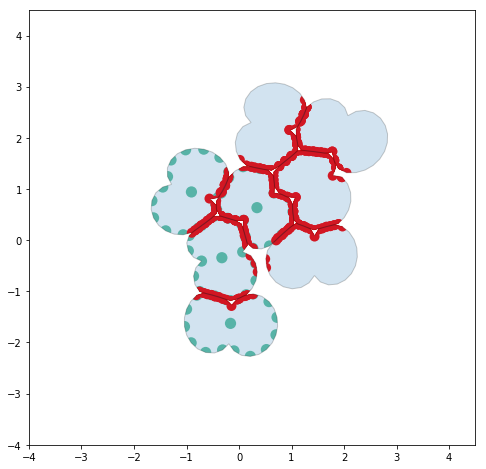

In [97]:
# print(mitotic_cleavage_vertices(cells[0]))
# for i in np.arange(len(cells)):
#   cells[i]['division'] = {
#     'between': mitotic_cleavage_vertices(cells[i]),
#     'stage': 0.1,
#   }

### Organism search

In [98]:
import genetics
from genetics import mutate_genome
import evolution
import cytology
import simulation

reload(genetics)
reload(evolution)
reload(cytology)
reload(simulation)


genomes, genome_map, genes, gene_map = evolution.init()

n_threads = 1
pool = Pool(n_threads)
epochs = 1

env_histories = []
cell_histories = []

for epoch in np.arange(epochs):
  # Decide on the parent subpopulation
  sorted_genomes, genome_weights = evolution.sort_genomes(genomes)
  
  sim_args = []
  start_genome_list = []
  for _ in np.arange(n_threads):
    env, cells = evolution.sample_batch(epoch, genomes, genome_map, sorted_genomes, genome_weights, genes, gene_map)

    gene_cell_map = {}
    for cell_idx, cell in enumerate(cells):
      for gene_id in genomes[cell['genome']]['genes']:
        if gene_id not in gene_cell_map:
          gene_cell_map[gene_id] = []
        gene_cell_map[gene_id].append(cell_idx)

    start_genomes = np.bincount([c['genome'] for c in cells])
    start_genome_list.append(start_genomes)

    n_steps = 250
#     simulate((env_p, env_p_map, cell_p, cell_p_map, resource_cost, cell2cell_diffusion, env2cell_diffusion, cell2env_diffusion, genomes, genes, gene_cell_map, cells, reactions, env, ground_level, n_steps))
#     simulation.simulate((env, cells, n_steps))
#     sim_args.append((env_p, env_p_map, cell_p, cell_p_map, resource_cost, cell2cell_diffusion, env2cell_diffusion, cell2env_diffusion, genomes, genes, gene_cell_map, cells, reactions, env, ground_level, n_steps))
    sim_args.append((env, cells, n_steps))
  
  result = pool.map_async(simulation.simulate, sim_args)
  all_genome_scores = []
#   for start_genomes, (cell_history, env_history) in zip(start_genome_list, result.get(timeout=600)):
  for start_genomes, (env_history, cell_history, all_membranes, nearby_membranes) in zip(start_genome_list, result.get(timeout=600)):
  #   cell_history, env_history = simulate(genomes, genes, gene_cell_map, cells, reactions, env, ground_level, n_steps)
#     print([c['genome'] for c in cell_history[-1]])
    genome_scores = np.bincount([c['genome'] for c in cell_history[-1]]) / np.maximum(start_genomes.astype(np.float32), 1.0)
    for i, s in enumerate(genome_scores):
      if s > 0:
        genomes[i]['fitness'].append(float(s))
    all_genome_scores.append(genome_scores)
  print('epoch {0}, max fitness {1}'.format(epoch, np.max(np.concatenate(all_genome_scores, axis=0))))
  env_histories.append(env_history)
  cell_histories.append(cell_history)
  
  
# cell_history, all_membranes, nearby_membranes = simulate(cells, 400)

epoch 0, max fitness 1.0


### Development timeline rendering

In [99]:
import rendering
from rendering import render_history
reload(rendering)

# print(cell_history[-1])
rendering.render_history(cell_history, env_history)

Rendering figures..


100%|██████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 38.15it/s]


### Profiling

In [21]:
%load_ext line_profiler

n_steps = 400
%lprun -f simulate simulate(cells, n_steps)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 151.46it/s]


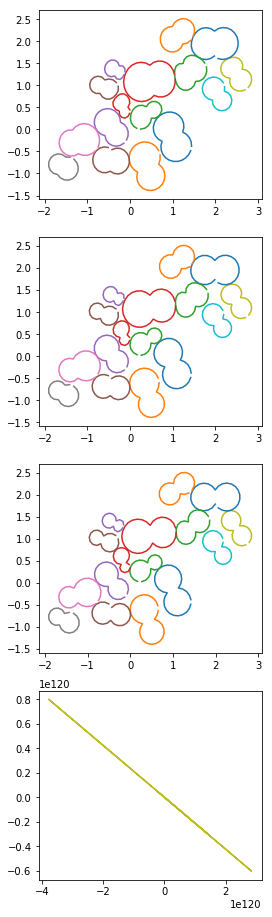

In [438]:
fig, ax = plt.subplots(len(cell_history[-4:]), figsize=(4, 16))
for i, h in enumerate(cell_history[-4:]):
# for c in cell_history[-2]:
  for j, c in enumerate(h):
#     print(j)
    ax[i].plot(c['membrane'][:,0], c['membrane'][:,1])
#     Polygon(c['membrane']).buffer(0).intersection(Polygon(c['membrane']).buffer(0))

c 0
0.0591776599828534
0.059220163197306344
0.059220163197306344
0.05914473180679917
0.05914473180679917
0.058720173470041284
0.058720173470041284
0.05839116080870465
0.05839116080870465
0.05815117685313126
0.05815117685313126
0.057672160511273315
0.057672160511273315
0.05740454058188444
0.05740454058188444
0.05705103190539878
0.05705103190539878
0.056348114436172
0.056348114436172
0.05591206863362135
0.05591206863362135
0.05575064012545271
0.05575064012545271
0.055842599450439956
0.055842599450439956
0.05596330087068212
0.05596330087068212
0.05633489470123318
0.05633489470123318
0.05393972258168759
0.05393972258168759
0.05381607960621291
0.05381607960621291
0.05396229293230959
0.05396229293230959
0.05424879927526696
0.05424879927526696
0.05457974794386857
0.05457974794386857
0.055363063599197196
0.055363063599197196
0.05589783069082926
0.05589783069082926
0.056014318610106056
0.056014318610106056
0.05590426538116965
0.05590426538116965
0.05591049293771222
0.05591049293771222
0.0561128

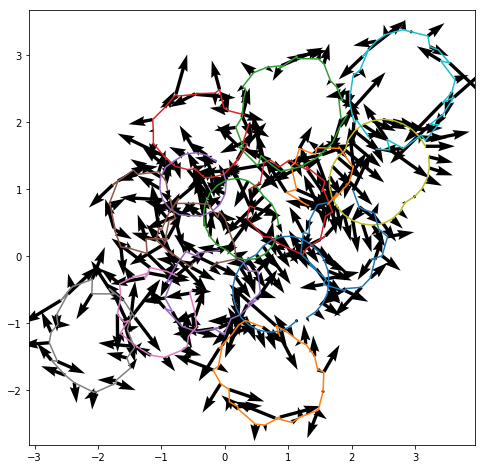

In [29]:
cells = cell_history[-2]

# next_cells = ~make_step(cells)
  

fig, ax = plt.subplots(figsize=(8,8))
for c in next_cells:
  ax.plot(c['membrane'][:,0], c['membrane'][:,1])
#   ax.add_patch(PolygonPatch(Polygon(c['membrane']), alpha=.3))
  ax.quiver(c['membrane'][:,0], c['membrane'][:,1], c['membrane_momentum'][:,0], c['membrane_momentum'][:,1])

[5.09901951 5.01864736]
[[ 0.63439328  0.77301045]
 [-0.77301045  0.63439328]]


(-2, 2)

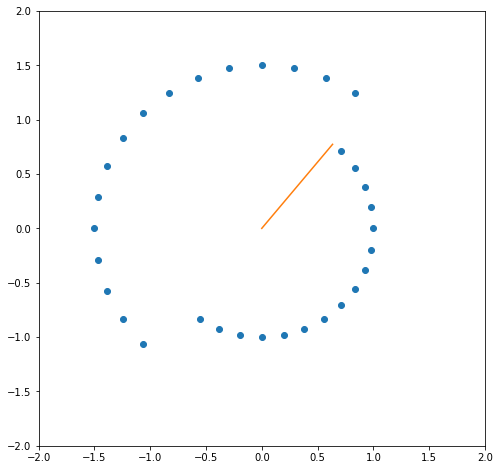

In [106]:
tring = np.copy(ring)
x = tring[:, 0]
y = tring[:, 1]
# x += 0.5 * tring[:, 1]
# y += 0.5 * tring[:, 0]
# y[5] *= 20.0
tring = np.stack([x, y], axis=1)
# A = np.vstack([x, np.ones(len(x))]).T
# m, c = np.linalg.lstsq(A, y, rcond=None)[0]

# _ = plt.plot(x, y, 'o', label='Original data', markersize=10)
# _ = plt.plot(x, m*x + c, 'r', label='Fitted line')
# # _ = plt.legend()

# from scipy import stats
# slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# print("slope: %f    intercept: %f" % (slope, intercept))
# print("std_err: %f" % std_err)

tring = tring / np.linalg.norm(tring, axis=1, keepdims=True)

tring[5:21] *= 1.5

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(tring)
print(pca.singular_values_)
print(pca.components_)

fix, ax = plt.subplots(figsize=(8,8))
ax.plot(tring[:, 0], tring[:, 1], 'o', label='original data')
# ax.plot(x, intercept + slope*x, 'r', label='fitted line')
ax.plot([0, pca.components_[0,0]], [0, pca.components_[0,1]])
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# print(np.array(list(Polygon(cell_history[-1][0]['membrane']).centroid.coords)))

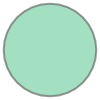

In [2]:
n_membrane_verts = 32
ring = np.array([(np.cos(a), np.sin(a)) for a in np.linspace(0, np.pi * 2, n_membrane_verts, endpoint=False)])
# ring += [ring[0]]
membrane = Polygon(ring)
membrane

(-2, 2.5)

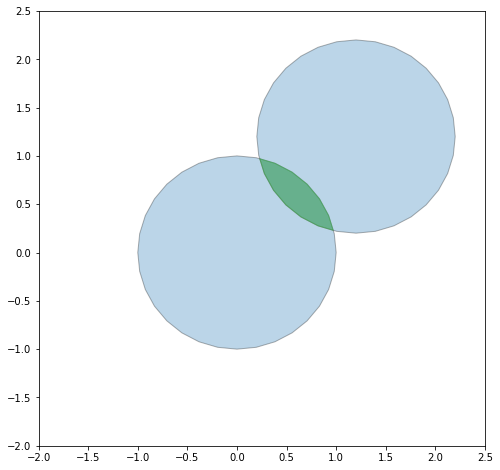

In [4]:
membrane2 = Polygon(ring)
membrane2 = affinity.translate(membrane2, 1.2, 1.2)
# MultiPolygon([membrane, membrane2])
fig, ax = plt.subplots(figsize=(8, 8))
ax.add_patch(PolygonPatch(membrane, alpha=.3))
ax.add_patch(PolygonPatch(membrane2, alpha=.3))
ax.add_patch(PolygonPatch(membrane.intersection(membrane2), color='#44aa44', alpha=.5))
ax.set_xlim(-2, 2.5)
ax.set_ylim(-2, 2.5)